In [1]:
import pandas as pd
import numpy as np

In [2]:
np.set_printoptions(suppress=True)
TIME_COLUMN_INDEX = 0
OPEN_COLUMN_INDEX = 1
CLOSE_COLUMN_INDEX = 4
VOLUME_COLUMN_INDEX = 5
window_size = 180
look_ahead = 5
train_split = 0.85

In [3]:
date_columns=["Date", "Time"]
df = pd.read_csv("data/trading/USDBTC60.csv", parse_dates=[date_columns])
df = df[~np.isnan(df['Close'])].set_index(pd.DatetimeIndex(df["Date_Time"]))

In [4]:
df.tail()
df.shape

(14161, 7)

In [5]:
def _normalize_column(df_column, normalize, pct_change):
    column = df_column.copy()
    if pct_change:
        column = column.pct_change()
    column = column.replace(np.inf, np.nan).fillna(0)
    eps = np.finfo(np.float32).eps
    column_n = (column - np.array(column.mean())) / np.array(column.std() + eps)
    return column if not normalize else column_n

def _normalize_state(normalize=True, pct_change=True):
    return np.array([
        df.index.to_pydatetime(),
        _normalize_column(df['Open'], normalize, pct_change).values,
        _normalize_column(df['High'], normalize, pct_change).values,
        _normalize_column(df['Low'], normalize, pct_change).values,
        _normalize_column(df['Close'], normalize, pct_change).values,
        _normalize_column(df['Volume'].fillna(0), normalize, pct_change).values,
    ]).T

In [6]:
state_norm = _normalize_state(True, True)
state_raw = _normalize_state(False, False)
state = state_raw

In [7]:
state_len = state.shape[0]
features_number = state.shape[1]
train_end_index = int(train_split * state_len)

In [8]:
train_state = state[0:train_end_index]
test_state = state[train_end_index:]
print("Train state: ", train_state.shape, "test state: ", test_state.shape)
train_length = train_end_index - window_size - look_ahead + 1
test_length = state_len - window_size - train_end_index - look_ahead + 1

Train state:  (12036, 6) test state:  (2125, 6)


In [9]:
def _norm_set(X_columns_set):
    mean = X_columns_set.mean()
    std = X_columns_set.std()
    return (X_columns_set - mean) / std, mean, std

def normalize_set(X_window_set):
    new_set = np.zeros_like(X_window_set)
    new_set[TIME_COLUMN_INDEX] = X_window_set[TIME_COLUMN_INDEX, :]
    new_set[OPEN_COLUMN_INDEX:CLOSE_COLUMN_INDEX+1], price_mean, price_std = _norm_set(X_window_set[OPEN_COLUMN_INDEX:CLOSE_COLUMN_INDEX+1, :])
    new_set[VOLUME_COLUMN_INDEX], _, _ = _norm_set(X_window_set[VOLUME_COLUMN_INDEX, :])
    return new_set, price_mean, price_std

In [10]:
def get_y_label(close_ahead_diff, window_std):
    return int((np.sign(close_ahead_diff) * int(np.abs(close_ahead_diff) - window_std/2 > 0))[0])

In [11]:
def get_window_diff(state, close_index, price_mean, price_std):
    last_window_close = state[close_index - 1, CLOSE_COLUMN_INDEX] - price_mean
    look_ahead_window_close = state[close_index - 1 + look_ahead, CLOSE_COLUMN_INDEX] - price_mean
    window_close_diff = look_ahead_window_close - last_window_close
    window_close_diff_norm = window_close_diff / price_std
    return window_close_diff_norm

In [12]:
def get_data(state, length):
    X_set = np.zeros((length, features_number, window_size), dtype=state.dtype)
    y_set = np.zeros((length, 1))
    std_set = np.zeros((length, 1))
    cl_diff_set = np.zeros((length, 1))
    price_meta_set = np.zeros((length, 2))

    for i in range(length):
        X_set[i, :, :], price_mean, price_std = normalize_set(state[i:i + window_size,:].T)
        cl_diff_set[i] = get_window_diff(state, i + window_size, price_mean, price_std)
        std_set[i] = 1  # here we normalise prices above, so std = 1
        y_set[i] = get_y_label(cl_diff_set[i], std_set[i])  
        price_meta_set[i] = [price_mean, price_std]
    return X_set, y_set, std_set, cl_diff_set, price_meta_set

In [13]:
X_train, y_train, std_train, cl_diff_train, price_meta_train = get_data(train_state, train_length)
print("Train dataset : ", X_train.shape, y_train.shape, std_train.shape, cl_diff_train.shape, price_meta_train.shape)

Train dataset :  (11852, 6, 180) (11852, 1) (11852, 1) (11852, 1) (11852, 2)


In [14]:
print("Buy:  ", cl_diff_train[10101], 1);assert(get_y_label(cl_diff_train[10101], std_train[10101]) == 1)
print("Hold: ", cl_diff_train[11300], 0);assert(get_y_label(cl_diff_train[11300], std_train[11300]) == 0)
print("Sell: ", cl_diff_train[11425], -1);assert(get_y_label(cl_diff_train[11425], std_train[11425]) == -1)

Buy:   [0.69765753] 1
Hold:  [0.03266786] 0
Sell:  [-0.79984143] -1


In [15]:
import matplotlib.pyplot as plt
plt.plot(np.abs(cl_diff_train))
plt.plot(std_train)
plt.show()

In [16]:
len(y_train[y_train > 0]), len(y_train[y_train == 0]), len(y_train[y_train < 0])

(1546, 9118, 1188)

In [17]:
X_test, y_test, std_test, cl_diff_test, price_meta_test = get_data(test_state, test_length)
print("Test dataset :  ", X_test.shape, "", y_test.shape, "", std_test.shape, "", cl_diff_test.shape, "", price_meta_test.shape)

Test dataset :   (1941, 6, 180)  (1941, 1)  (1941, 1)  (1941, 1)  (1941, 2)


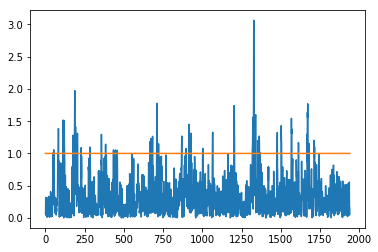

In [18]:
import matplotlib.pyplot as plt
plt.plot(np.abs(cl_diff_test))
plt.plot(std_test)
plt.show()

In [19]:
len(y_test[y_test > 0]), len(y_test[y_test == 0]), len(y_test[y_test < 0])

(247, 1471, 223)

In [20]:
from utils.renderer import render

def render_for_index(X_set, y_set, meta_set, index, denormalize=False):
    values = X_set[index + look_ahead].copy()
    if denormalize:
        values[OPEN_COLUMN_INDEX:CLOSE_COLUMN_INDEX+1] *= price_meta_train[index + look_ahead][1]
        values[OPEN_COLUMN_INDEX:CLOSE_COLUMN_INDEX+1] += price_meta_train[index + look_ahead][0]
    trades = np.zeros((2, values.shape[1]))
    trade_values = np.concatenate((values, trades), axis=0)
    print("Index: ", index, " Rendering for index+5:", index+5, "Y value:",  y_set[index])
    render(trade_values.T, title="X", scale=1)

Index:  11402  Rendering for index+5: 11407 Y value: [1.]


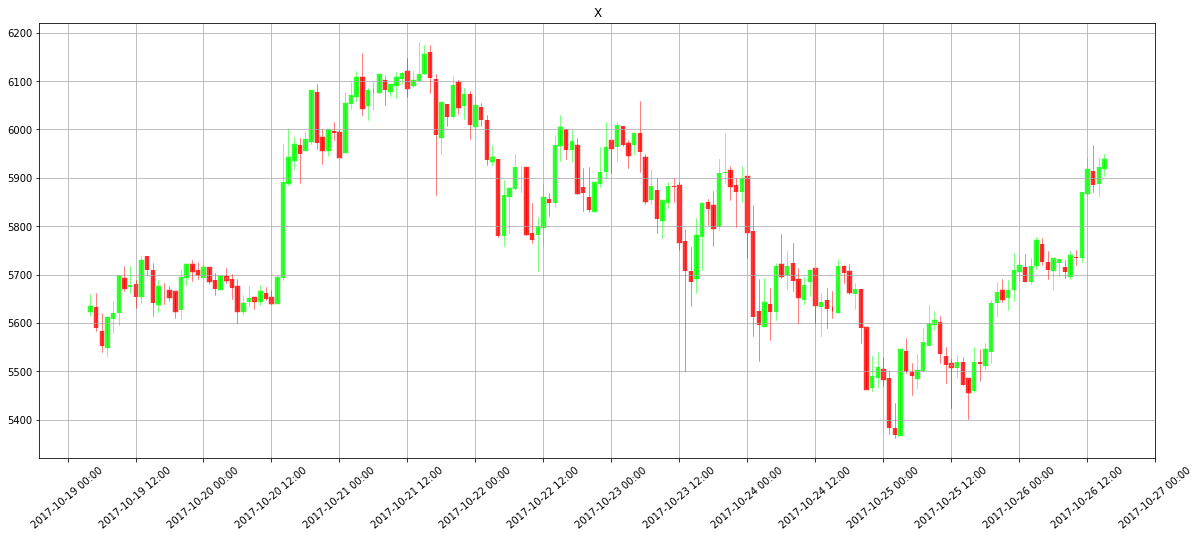

In [21]:
render_for_index(X_train, y_train, price_meta_train, index=11402, denormalize=True)

In [22]:
print("Train dataset : ", X_train.shape, y_train.shape, price_meta_train.shape)
print("Test dataset : ", X_test.shape, y_test.shape, price_meta_test.shape)
print("Train dataset metrics : ", X_train[:, 1:].mean(), X_train[:, 1:].std())
print("Test dataset : ", X_test[:, 1:].mean(), X_test[:, 1:].std())
print("Nb classes : ", len(np.unique(y_train)))

Train dataset :  (11852, 6, 180) (11852, 1) (11852, 2)
Test dataset :  (1941, 6, 180) (1941, 1) (1941, 2)
Train dataset metrics :  1.8462631966163924e-16 0.9999999999999701
Test dataset :  -6.963350396735732e-16 1.0000000000000109
Nb classes :  3


In [23]:
FOLDER = "data/trading/"
np.save(FOLDER + 'X_train.npy', X_train)
np.save(FOLDER + 'y_train.npy', y_train)
np.save(FOLDER + 'price_meta_train.npy', price_meta_train)
np.save(FOLDER + 'X_test.npy', X_test)
np.save(FOLDER + 'y_test.npy', y_test)
np.save(FOLDER + 'price_meta_test.npy', price_meta_test)